In [193]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from scipy.ndimage import binary_erosion, binary_dilation

In [194]:
def show_images(images, columns=2, figsize=(10, 10)):
    
    if isinstance(images, np.ndarray):
        images = [images]
    rows = (len(images) + columns - 1) // columns
    fig, axes = plt.subplots(rows, columns, figsize=figsize)
    axes = np.array(axes).flatten()
    for i, img in enumerate(images):
        axes[i].imshow(img, cmap='gray', interpolation='none')
        axes[i].axis('off')
    for i in range(len(images), len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [195]:

image_path = 'car.png'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
binary_image = original_image > 127 

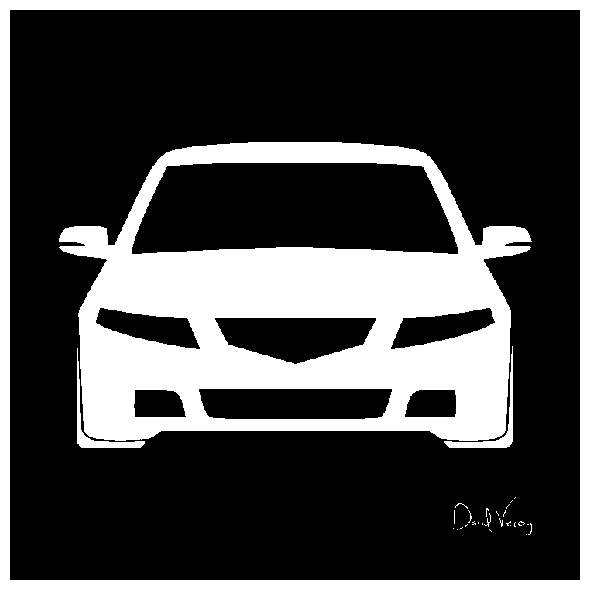

In [196]:
show_images(binary_image, columns=1, figsize=(6, 6))

In [197]:
def create_structuring_element(shape, size):
    
    if shape == 'cross':
        element = cv2.getStructuringElement(cv2.MORPH_CROSS, (size, size))
    elif shape == 'rectangle':
        element = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    elif shape == 'ellipse':
        element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))
    elif shape == 'circle':
        element = np.array([
            [
                np.hypot(row, col) <= size for col in range(-size, size + 1)
            ] for row in range(-size, size + 1)
        ], dtype=np.uint8)
    else:
        raise ValueError(f"Неизвестная форма: {shape}")
    return element

structuring_elements = {
    'Крест': create_structuring_element('cross', 5),
    'Прямоугольник': create_structuring_element('rectangle', 5),
    'Эллипс': create_structuring_element('ellipse', 5),
    'Круг': create_structuring_element('circle', 3)
}

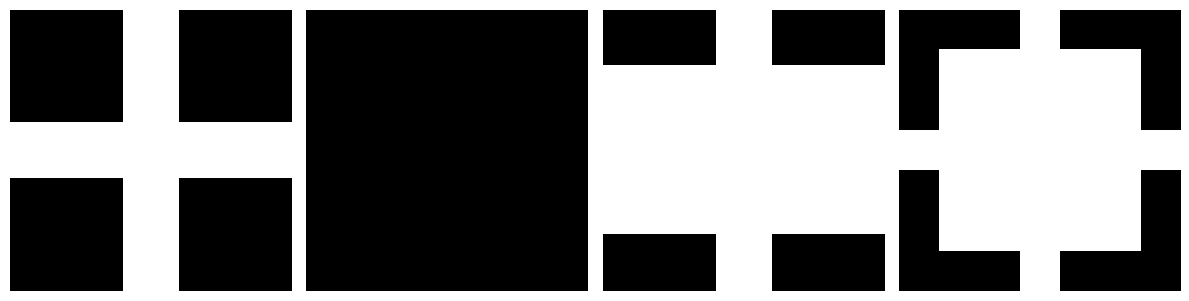

In [198]:
show_images(list(structuring_elements.values()), columns=4, figsize=(12, 4))

In [199]:
def compute_skeleton(binary_img, struct_elem, return_all_steps=False):
    
    binary_img = binary_img.astype(bool)
    struct_elem = struct_elem.astype(bool)
    skeleton = np.zeros_like(binary_img, dtype=bool)
    steps = [] if return_all_steps else None

    while True:
        eroded = binary_erosion(binary_img, structure=struct_elem)
        if not eroded.any():
            break
        temp = binary_dilation(eroded, structure=struct_elem)
        diff = binary_img & ~temp
        skeleton |= diff
        if return_all_steps:
            steps.append(diff)
        binary_img = eroded

    if return_all_steps:
        steps.append(binary_img)
        return steps
    else:
        return skeleton

In [200]:
def reconstruct_image(steps, struct_elem):
    reconstructed = np.zeros_like(steps[0], dtype=bool)
    for step in reversed(steps):
        reconstructed = binary_dilation(reconstructed, struct_elem) | step
    return reconstructed

Обработка с использованием структурирующего элемента: Крест


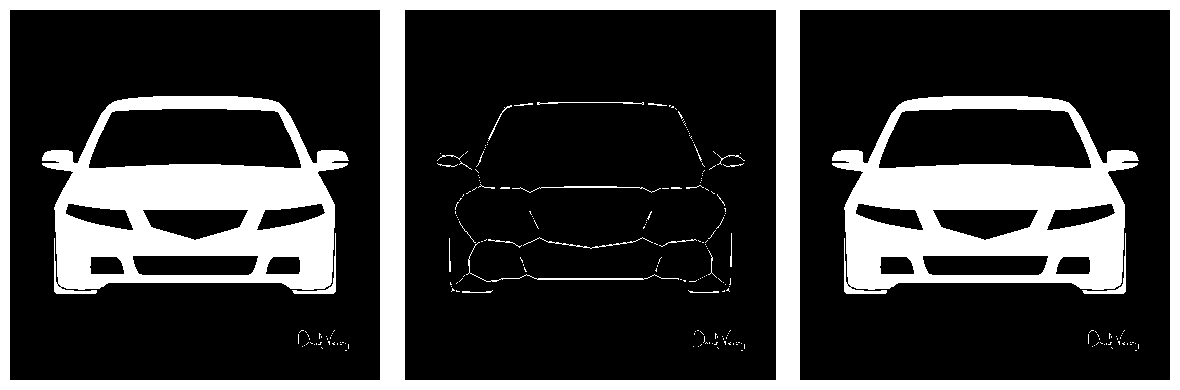

Обработка с использованием структурирующего элемента: Прямоугольник


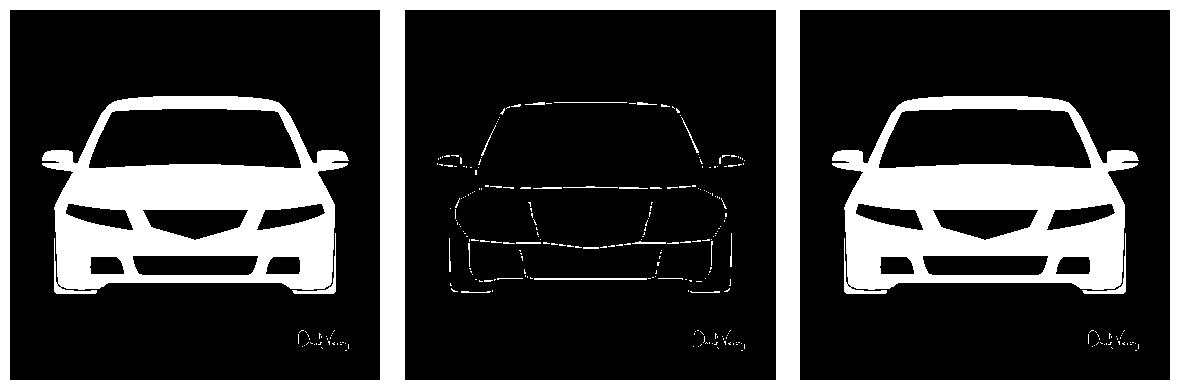

Обработка с использованием структурирующего элемента: Эллипс


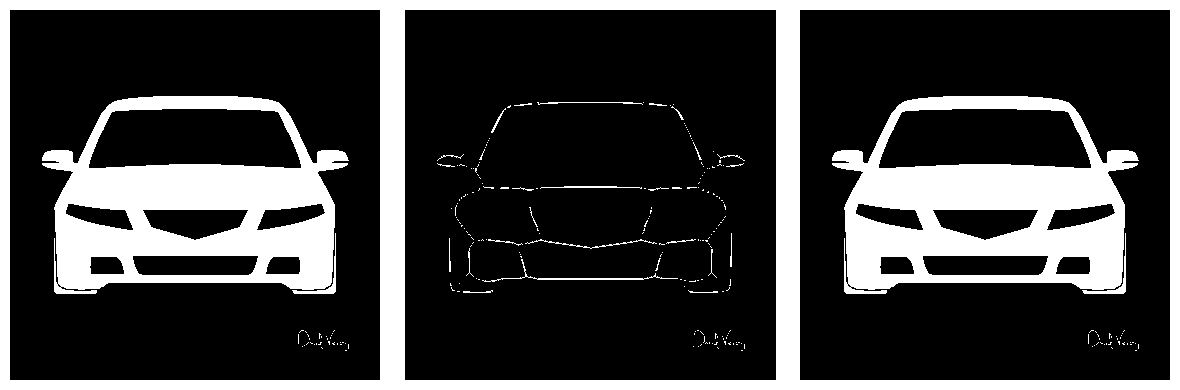

Обработка с использованием структурирующего элемента: Круг


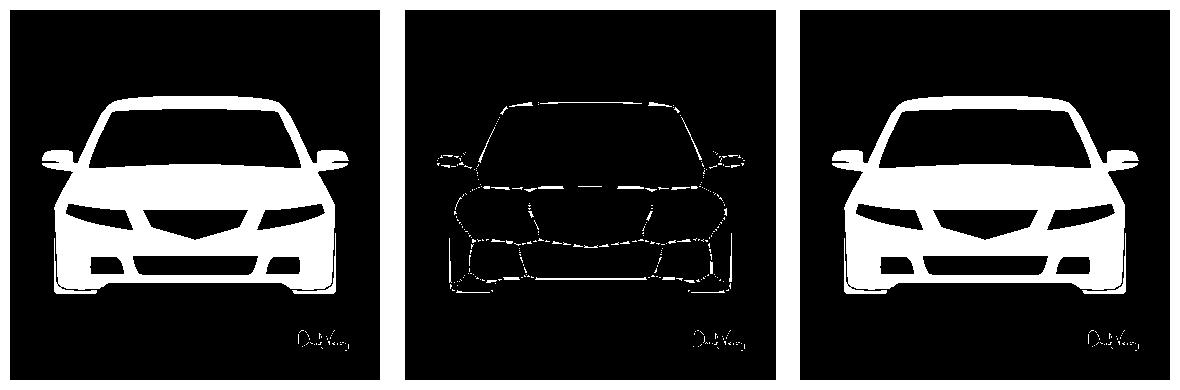

In [ ]:
for name, struct_elem in structuring_elements.items():
    print(f"Обработка с использованием структурирующего элемента: {name}")

    skeleton_steps = compute_skeleton(binary_image, struct_elem, return_all_steps=True)
    skeleton_image = np.any(skeleton_steps, axis=0)

    reconstructed_image = reconstruct_image(skeleton_steps, struct_elem)

    show_images(
        [binary_image, skeleton_image, reconstructed_image],
        columns=3,
        figsize=(12, 4)  
    )
    